In [3]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import conversion_equations as ce
import pickle
import os
from matplotlib.colors import Normalize
import ast
import seaborn as sns
import itertools as it
from pymodulon.io import load_json_model
from sklearn.metrics import r2_score

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)
flags_df = flags_df[flags_df['include']]

TF_flags_df = pd.read_csv('../data/TF_flags_expanded.csv', index_col = 0)

iM_table = pd.read_csv('../data/precise_1k/iM_table.csv', index_col = 0)
k_to_iM = {str(index) : row['name'] for index, row in iM_table.iterrows()}
M_df = pd.read_csv('../data/precise_1k/M.csv', index_col = 0).rename(columns = k_to_iM)
A_df = pd.read_csv('../data/precise_1k/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})

TRN_df = pd.read_pickle('../data/regulonDB_files/TRN_df.pkl')
p1k = load_json_model('../data/precise_1k/precise1k.json')

In [3]:
# first we need to make a ratio df
if False: # change to True to run again
    cases = set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()])
    collect_actuals = []
    collect_predictions = []
    for iMs_run in cases:
        clean = [x for x in iMs_run if str(x) != 'nan']
        case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
        if not os.path.exists('../GAMs/optimization_runs/'+case):
            continue

        # let's find our run_dir
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue # Usually means it hasn't been run yet
        actual_ratio = ce.log_tpm_df_to_mRNA_ratio_df(log_tpm_df.loc[mRNA_df.columns], flags_df.loc[mRNA_df.columns])

        collect_actuals.append(actual_ratio)
        collect_predictions.append(mRNA_df)

    merge_actual = pd.concat(collect_actuals, axis = 1)
    merge_pred = pd.concat(collect_predictions, axis = 1)
    overlap = list(set(merge_actual.index).intersection(set(merge_pred.index)))
    actual_mRNA_df = merge_actual.loc[:,~merge_actual.columns.duplicated()].astype(float)
    pred_mRNA_df = merge_pred.loc[:,~merge_pred.columns.duplicated()].astype(float)

    # create sample-sample and gene-gene correlation dataframe
    sample_corr_df = pd.DataFrame(index = actual_mRNA_df.index, columns = actual_mRNA_df.index)
    for sample1 in actual_mRNA_df.index:
        for sample2 in actual_mRNA_df.index:
            sample_corr_df.at[sample1, sample2] = actual_mRNA_df.loc[sample1].corr(pred_mRNA_df.loc[sample2])
    gene_corr_df = pd.DataFrame(index = actual_mRNA_df.columns, columns = actual_mRNA_df.columns)
    for sample1 in actual_mRNA_df.columns:
        for sample2 in actual_mRNA_df.columns:
            gene_corr_df.at[sample1, sample2] = actual_mRNA_df[sample1].corr(pred_mRNA_df[sample2])

    # these things take a while to run, let's save them off
    sample_corr_df.to_csv('../data/samples_correlation_df.csv')
    gene_corr_df.to_csv('../data/genes_correlation_df.csv')
else:
    # load in
    sample_corr_df = pd.read_csv('../data/samples_correlation_df.csv', index_col = 0)
    gene_corr_df = pd.read_csv('../data/genes_correlation_df.csv', index_col = 0)

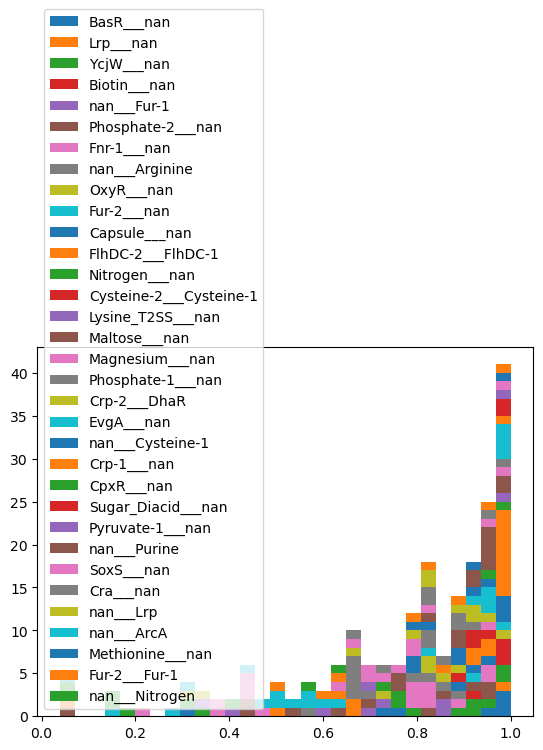

In [4]:
# stacked histogram - try rerunning once all samples run

case_to_genes = {}
case_to_avr_corr = {}
plot_vals = []
plot_labels = []
for iMs_run in set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    # let's find our run_dir
    try:
        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
        mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    except:
        continue # Usually means it hasn't been run yet
    plot_labels.append(case)
    plot_vals.append(np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]))
    case_to_avr_corr.update({case : np.mean(np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]))})
plt.hist(plot_vals, stacked = True, bins = 30, label = plot_labels)
plt.legend()
plt.show()

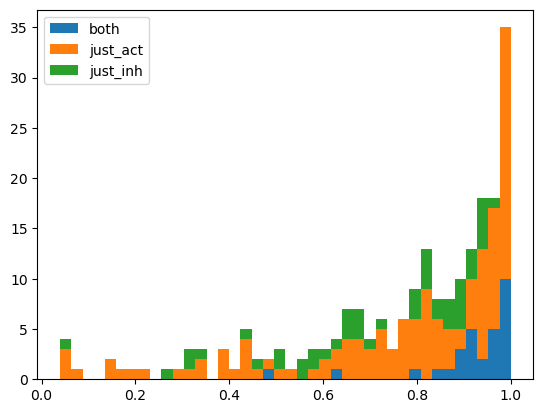

In [5]:
# same as above, but split by case type (dual regulator, all inhibitor, all activator)

type_to_cases = {
    'both' : [],
    'just_act' : [],
    'just_inh' : []
}
for iMs_run in set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()]):
    if str(iMs_run[0]) != 'nan' and str(iMs_run[1]) != 'nan':
        type_to_cases['both'].append(iMs_run)
    elif str(iMs_run[0]) != 'nan' and str(iMs_run[1]) == 'nan':
        type_to_cases['just_act'].append(iMs_run)
    elif str(iMs_run[0]) == 'nan' and str(iMs_run[1]) != 'nan':
        type_to_cases['just_inh'].append(iMs_run)
plot_vals = []
plot_labels = []
for type, cases in type_to_cases.items():
    plot_labels.append(type)
    temp_plot_vals = []
    for iMs_run in cases:
        case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
        # let's find our run_dir
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue # Usually means it hasn't been run yet
        for val in np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]):
            temp_plot_vals.append(val)
    plot_vals.append(temp_plot_vals)
plt.hist(plot_vals, stacked = True, bins = 40, label = plot_labels)
plt.legend()
plt.savefig('../figures/gene_pred_corrs_histogram.pdf', transparent = True)
plt.show()

In [6]:
# what's wrong with the terrible ones?
worst_cases = [k for k, _ in sorted(case_to_avr_corr.items(), key = lambda k : k[1])]
for case in worst_cases:
    print(case+' : '+str(case_to_avr_corr[case]))

CpxR___nan : 0.30144171437602796
nan___ArcA : 0.40837171532252786
Crp-1___nan : 0.5747694323259788
nan___Nitrogen : 0.6013679069356074
SoxS___nan : 0.6174286648821876
nan___Lrp : 0.6597266399222557
Pyruvate-1___nan : 0.6706441210087507
Lysine_T2SS___nan : 0.6992608279472404
Phosphate-2___nan : 0.6996310419575696
Lrp___nan : 0.7054358771564305
nan___Arginine : 0.7143071887402124
nan___Fur-1 : 0.7466030759245006
Fur-2___nan : 0.757916306708747
Fur-2___Fur-1 : 0.7995073425743434
Maltose___nan : 0.8011898154287489
OxyR___nan : 0.8084283723107992
BasR___nan : 0.8116593390565912
YcjW___nan : 0.8181717101886615
Cra___nan : 0.820573778499465
Magnesium___nan : 0.8303875308785374
Fnr-1___nan : 0.8459289039468156
Nitrogen___nan : 0.8535954668266006
nan___Cysteine-1 : 0.8610074776754811
Phosphate-1___nan : 0.8679930517565047
EvgA___nan : 0.8747891394160638
Methionine___nan : 0.91221240223478
Crp-2___DhaR : 0.918058515694116
nan___Purine : 0.9181944667756226
Cysteine-2___Cysteine-1 : 0.921612181419

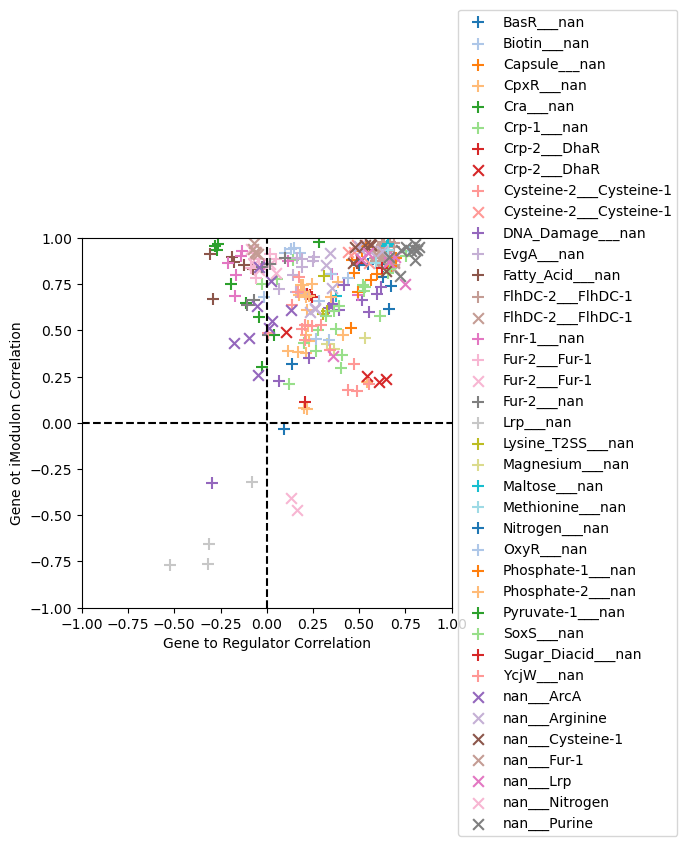

In [111]:
# correlation between gene and regulator, gene and iModulon
# settings
colors = list(cm.tab20.colors)
markers = ['o', 'x']


gene_reg_corrs = []
gene_iM_corrs = []
act_or_inhs = []
labels = []
cases = []
for iMs_run in set([(str(row['act_iM']), str(row['inh_iM'])) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    
    # limit down
    keep = []
    for index, row in flags_df.iterrows():
        if str(row['act_iM']) == iMs_run[0] and str(row['inh_iM']) == iMs_run[1]:
            keep.append(index)
    bby_flags = flags_df.loc[keep]
    dual_case = False
    if iMs_run[0] != 'nan' and iMs_run[1] != 'nan':
        dual_case = True
    elif iMs_run[0] == 'nan':
        iM_use = iMs_run[1].replace('_', '/')
        act_or_inh = 'inh'
    elif iMs_run[1] == 'nan':
        iM_use = iMs_run[0].replace('_', '/')
        act_or_inh = 'act'
    to_add = TF_flags_df.loc[iM_use].gene_name

    # generate values
    if not dual_case:
        for key, val in log_tpm_df.loc[bby_flags.index.to_list()+[to_add]].T.corr()[to_add].items():
            if key != to_add:
                gene_reg_corrs.append(val)
        overlap = list(set(A_df.columns.intersection(log_tpm_df.columns)))
        for gene in bby_flags.index:
            corr = np.corrcoef(log_tpm_df.loc[gene][overlap], A_df.loc[iM_use][overlap])[0, 1]
            gene_iM_corrs.append(corr)
            labels.append(gene)
            cases.append(case)
            act_or_inhs.append(act_or_inh)
    else:
        for iM, act_or_inh in zip(iMs_run, ['act', 'inh']):
            iM_use = iM.replace('_', '/')
            to_add = TF_flags_df.loc[iM_use].gene_name
            for key, val in log_tpm_df.loc[bby_flags.index.to_list()+[to_add]].T.corr()[to_add].items():
                if key != to_add:
                    gene_reg_corrs.append(val)
            overlap = list(set(A_df.columns.intersection(log_tpm_df.columns)))
            for gene in bby_flags.index:
                corr = np.corrcoef(log_tpm_df.loc[gene][overlap], A_df.loc[iM_use][overlap])[0, 1]
                gene_iM_corrs.append(corr)
                labels.append(gene)
                cases.append(case)
                act_or_inhs.append(act_or_inh)

corrs_df = pd.DataFrame(index = labels)
corrs_df['gene_reg_corrs'] = gene_reg_corrs
corrs_df['gene_iM_corrs'] = gene_iM_corrs
corrs_df['cases'] = cases
corrs_df['act_or_inhs'] = act_or_inhs

case_to_marker = {
    'act' : '+',
    'inh' : 'x',
}
iM_to_color = {}
mark_col = it.product(markers, colors)
for case, df in corrs_df.groupby('cases'):
    mark, col = next(mark_col)
    iM_to_color.update({case : col})
    for case2, df2 in df.groupby('act_or_inhs'):
        marker = case_to_marker[case2]
        if marker == '+':
            size = 80
        else:
            size = 60
        plt.scatter(df2['gene_reg_corrs'], df2['gene_iM_corrs'], s = size, label = case, color = col, marker = marker)
plt.xlabel('Gene to Regulator Correlation')
plt.ylabel('Gene to iModulon Correlation')
plt.axvline(x = 0, ls = '--', c = 'k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = 0, ls = '--', c = 'k')
plt.axis('square')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.savefig('../figures/gene_iM_corrs.pdf', transparent = True)
plt.show()

NameError: name 'all_xs' is not defined

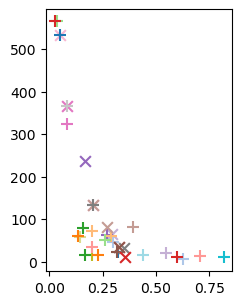

In [129]:
# also iM genes, regulon overlap
#p1k = load_json_model('../data/precise_1k/precise1k.json')
#TRN_df = TRN_df = pd.read_pickle('../data/regulonDB_files/TRN_df.pkl')

p1k.view_imodulon('Arginine').columns


# correlation between gene and regulator, gene and iModulon
# settings
colors = list(cm.tab20.colors)
markers = ['o', 'x']


jaccard_sims = []
reg_size = []
act_or_inhs = []
cases = []
for iMs_run in set([(str(row['act_iM']), str(row['inh_iM'])) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    
    # limit down
    keep = []
    for index, row in flags_df.iterrows():
        if str(row['act_iM']) == iMs_run[0] and str(row['inh_iM']) == iMs_run[1]:
            keep.append(index)
    bby_flags = flags_df.loc[keep]
    dual_case = False
    if iMs_run[0] != 'nan' and iMs_run[1] != 'nan':
        dual_case = True
    elif iMs_run[0] == 'nan':
        iM_use = iMs_run[1].replace('_', '/')
        act_or_inh = 'inh'
    elif iMs_run[1] == 'nan':
        iM_use = iMs_run[0].replace('_', '/')
        act_or_inh = 'act'
    to_add = TF_flags_df.loc[iM_use].gene_name
    
    
    # generate values
    if not dual_case:
        iM_genes = set(p1k.view_imodulon(iM_use).index.to_list())
        regulon = set(TRN_df.columns[TRN_df.loc[to_add] != 0].to_list())
        jaccard_sims.append(len(iM_genes.intersection(regulon)) / len(iM_genes.union(regulon)))
        act_or_inhs.append(act_or_inh)
        cases.append(case)
        reg_size.append(len(regulon))
    else:
        for iM, act_or_inh in zip(iMs_run, ['act', 'inh']):
            iM_use = iM.replace('_', '/')
            to_add = TF_flags_df.loc[iM_use].gene_name
            iM_genes = set(p1k.view_imodulon(iM_use).index.to_list())
            regulon = set(TRN_df.columns[TRN_df.loc[to_add] != 0].to_list())
            jaccard_sims.append(len(iM_genes.intersection(regulon)) / len(iM_genes.union(regulon)))
            act_or_inhs.append(act_or_inh)
            cases.append(case)
            reg_size.append(len(regulon))
jacc_df = pd.DataFrame(index = cases)
jacc_df['jaccard_sims'] = jaccard_sims
jacc_df['reg_size'] = reg_size
jacc_df['act_or_inhs'] = act_or_inhs


case_to_marker = {
    'act' : '+',
    'inh' : 'x',
}
plt.figure(figsize = (12/5, 17/5))
for index, row in jacc_df.iterrows():
    color = iM_to_color[index]
    marker = case_to_marker[row['act_or_inhs']]
    if marker == '+':
        size = 80
    else:
        size = 60
    plt.scatter(row['jaccard_sims'], row['reg_size'], s = size, label = index, color = color, marker = marker)
plt.xlabel('Jaccard Similarity')
plt.ylabel('Regulator Size')
#plt.axvline(x = 0, ls = '--', c = 'k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.axhline(y = 0, ls = '--', c = 'k')
#plt.axis('square')
#plt.xlim([-1, 1])
#plt.ylim([-1, 1])
plt.savefig('../figures/jaccard_scores.pdf', transparent = True)
plt.show()

In [5]:
# I want to check out the specific examples where metabolite concentrations can be compared to P1K_metadata
p1k_effectors_to_samples = {
    'FructoseN/A1,6N/ABisphosphate' : ['p1k_00084', 'p1k_00085', 'p1k_00088', 'p1k_00089', 
        'p1k_00105', 'p1k_00116', 'p1k_00117', 'p1k_00118'],
    'Leucine/Isoleucine' : ['p1k_00171', 'p1k_00172'],
    'Arginine' : ['p1k_00165', 'p1k_00166', 'p1k_00277', 'p1k_00278'],
    'Phosphoenolpyruvate' : ['p1k_00062', 'p1k_00063', 'p1k_00183', 'p1k_00184', 'p1k_00279', 
        'p1k_00280', 'p1k_00463', 'p1k_00464', 'p1k_00507', 'p1k_00508'],
}
effector_to_cases = {
    'FructoseN/A1,6N/ABisphosphate' : ['Cra___nan'],
    'Leucine/Isoleucine' : ['Lrp___nan', 'nan___Lrp'],
    'Arginine' : ['nan___Arginine'],
    'Phosphoenolpyruvate' : [],
}

for effector, samples in p1k_effectors_to_samples.items():
    # let's find the cases
    cases = effector_to_cases[effector]
    
    # loop through cases, make some type of highlighted violin plot?
    for case in cases:
        # load
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue
        efe = fef
        # ZZZ XXX TODO - finish this code, I couldn't because the optimization runs are on another fork and I do not feel like fixing that